In [103]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
n_words_to_skip = 50
max_review_length = 100
pad_type = 'pre'
trunc_type = 'pre'

n_unique_words = 5000
n_dim = 64

output_dir = '/content/drive/MyDrive/Deep Learning/week15/model_output'

n_dense = 64
dropout = 0.5
epochs = 3
batch_size = 128

In [105]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()

In [106]:
word_index = imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()}

word_index["START"] = 1

index_word = {v:k for k,v in word_index.items()}

In [107]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(skip_top=n_words_to_skip, num_words=n_unique_words)

In [108]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [109]:
model = Sequential()
model.add(Embedding(n_unique_words,
          n_dim,
          input_length=max_review_length))

model.add(Flatten())
model.add(Dense(n_dense,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [110]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 64)           320000    
                                                                 
 flatten_3 (Flatten)         (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                409664    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [113]:
model.fit(x_train, y_train,
     batch_size = batch_size,
     epochs = epochs,
     verbose = 1,
     validation_data=(x_test,y_test),
     callbacks = [modelcheckpoint])

Epoch 1/3
196/196 [==============================] - 10s 44ms/step - loss: 0.5750 - accuracy: 0.6698 - val_loss: 0.3543 - val_accuracy: 0.8431
Epoch 2/3
196/196 [==============================] - 5s 27ms/step - loss: 0.2948 - accuracy: 0.8817 - val_loss: 0.3472 - val_accuracy: 0.8478
Epoch 3/3
196/196 [==============================] - 5s 25ms/step - loss: 0.1263 - accuracy: 0.9592 - val_loss: 0.4299 - val_accuracy: 0.8316


In [114]:
model.load_weights(output_dir + "/weights.02.hdf5")
y_hat = model.predict(x_test)

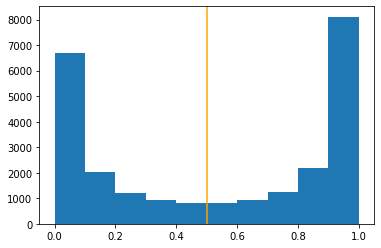

In [115]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [116]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'92.92'

In [117]:
import numpy as np
from numpy import trapz

In [118]:
def My_Area(arr):
  
  n = len(arr)
  sum = 0
  y0 = 1
  x0 = 1
  for x,y in arr:
    sum+=(y0+y)*(x0-x)/2
    y0 = y
    x0 = x

  return sum

In [119]:
def My_roc_auc_score(yy_test, yy_hat ,color):
  N = len(yy_hat)
  ds=np.linspace(0.0,1.0,100)
  
  TPRs = []
  FPRs = []

  for d in ds:
    TN, FN, FP, TP = 0, 0, 0, 0
    for i in range(1,N):
      if (yy_hat[i] <= d):
        if(yy_test[i] == 0):
          TN+=1
        else:
          FN+=1
      else:
        if(yy_test[i] == 1):
          TP+=1
        else:
          FP+=1
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN) if (FP+TN) != 0 else 0
    TPRs.append(TPR)
    FPRs.append(FPR)


  ArrData = list(zip(FPRs, TPRs))
  sorted(ArrData, key=lambda x: x[1])

  plt.figure()
  plt.plot(FPRs, TPRs, color)

  return My_Area(ArrData), TPRs, FPRs

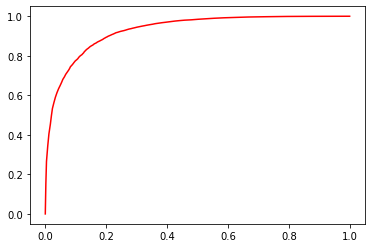

In [120]:
My_RAS1, TPRs1, FPRs1 = My_roc_auc_score(y_test, y_hat, 'red')

In [121]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
print("算出來的值為{:0.2f}，誤差百分比為{:0.2f}".format(My_RAS1*100.0, pct_auc - My_RAS1*100.0))

算出來的值為92.91，誤差百分比為0.01


In [122]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D

In [123]:
output_dir_conv = '/content/drive/MyDrive/Deep Learning/week15/model_outputConv'

epochs = 3
batch_size = 128

n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = 'pre'
trunc_type = 'pre'
drop_emed = 0.2

n_conv = 256
k_conv = 3

n_dense = 256
dropout = 0.2

(x_train, y_train), (x_test, y_test) = imdb.load_data(skip_top=n_words_to_skip, num_words=n_unique_words)

x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_test = pad_sequences(x_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [124]:
model_conv = Sequential()

model_conv.add(Embedding(n_unique_words,
          n_dim,
          input_length=max_review_length))
model_conv.add(SpatialDropout1D(drop_emed))


model_conv.add(Conv1D(n_conv, k_conv, activation='relu'))
model_conv.add(GlobalAveragePooling1D())

model_conv.add(Dense(n_dense, activation='relu'))
model_conv.add(Dropout(dropout))

model_conv.add(Dense(1, activation='sigmoid'))

In [125]:
model_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 400, 64)           320000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 400, 64)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 398, 256)          49408     
                                                                 
 global_average_pooling1d_1   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [126]:
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [127]:
modelcheckpoint_conv = ModelCheckpoint(filepath=output_dir_conv+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir_conv):
  os.makedirs(output_dir_conv)

In [128]:
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
model_conv.fit(x_train, y_train,
     batch_size = batch_size,
     epochs = epochs,
     verbose = 1,
     validation_data=(x_test,y_test),
     callbacks = [modelcheckpoint_conv])

Epoch 1/3
196/196 [==============================] - 104s 529ms/step - loss: 0.5348 - accuracy: 0.7119 - val_loss: 0.3183 - val_accuracy: 0.8720
Epoch 2/3
196/196 [==============================] - 96s 492ms/step - loss: 0.2659 - accuracy: 0.8952 - val_loss: 0.2812 - val_accuracy: 0.8845
Epoch 3/3
196/196 [==============================] - 93s 476ms/step - loss: 0.2203 - accuracy: 0.9148 - val_loss: 0.2856 - val_accuracy: 0.8804


In [130]:
model_conv.load_weights(output_dir_conv + "/weights.02.hdf5")
y_hat_conv = model_conv.predict(x_test)

'95.18'

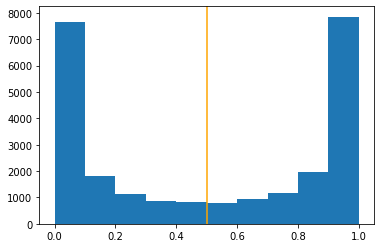

In [131]:
plt.hist(y_hat_conv)
_ = plt.axvline(x=0.5, color='orange')
pct_auc = roc_auc_score(y_test, y_hat_conv)*100.0
"{:0.2f}".format(pct_auc)

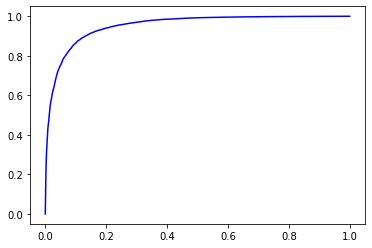

In [132]:
My_RAS2, TPRs2, FPRs2 = My_roc_auc_score(y_test, y_hat_conv, 'blue')

In [133]:
pct_auc = roc_auc_score(y_test, y_hat_conv)*100.0
print("算出來的值為{:0.2f}，誤差百分比為{:0.2f}".format(My_RAS2*100.0, pct_auc - My_RAS2*100.0))

算出來的值為95.17，誤差百分比為0.01


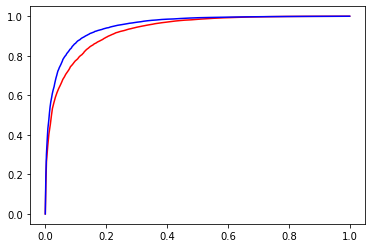

In [134]:
plt.figure()
plt.plot(FPRs1,TPRs1,'red')
plt.plot(FPRs2,TPRs2,'blue')
plt.show()